In [55]:
import yfinance as yfin
import numpy as np
from numpy import  log, polyfit, sqrt, std, subtract
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import  adfuller
from scipy.stats import probplot
from arch import arch_model
import warnings


warnings.filterwarnings("ignore")

yfin.pdr_override()

# Fetch historical data
ticker = 'GOOGL'
start_date = '2017-01-01'
end_date = '2019-12-31'
data = yfin.download(ticker, start=start_date, end=end_date, interval='1D')
prices = data['Close']

# Prepare data
prices.index = pd.DatetimeIndex(prices.index)
prices = prices.asfreq('D')
if prices.isna().any():
    prices = prices.ffill()

# Split the data into training and test sets
train_size = int(len(prices) * 0.9)  # Use 90% of data for training
train_prices, test_prices = prices[:train_size], prices[train_size:]

# get log returns
returns = prices.pct_change()*100

# we can drop the days with no prices because we consider th
returns.dropna(inplace=True)


[*********************100%%**********************]  1 of 1 completed


### Hurst Exponent

The Hurst Exponent is a statistical measure used to classify time series and infer the level of difficulty in predicting and choosing an appropriate model for the series at hand. The Hurst exponent is used as a measure of long-term memory of time series. It relates to the autocorrelations of the time series, and the rate at which these decrease as the lag between pairs of values increases.

- Value near 0.5 indicates a random series.
- Value near 0 indicates a mean reverting series.
- Value near 1 indicates a trending series.

In [56]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

# stats = f'ADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'

stat_test = adfuller(returns)
print(f"The test statistic and p-value of ADF test are {stat_test}")
if stat_test[1] < 0.05:
    print("The data is stationary")
else:
    print("The data is not stationary")

hurst_stat = round(hurst(returns.values),2)

# print for different case of hurst_stat

print(f"The Hurst Exponent is {hurst_stat}")

The test statistic and p-value of ADF test are (-13.463113498733614, 3.4984186406732886e-25, 7, 1083, {'1%': -3.436402509014354, '5%': -2.8642124318084456, '10%': -2.568192893555997}, 3433.739573455086)
The data is stationary
The Hurst Exponent is 0.01


The hurst exponent indicates the returns are mean reverting.

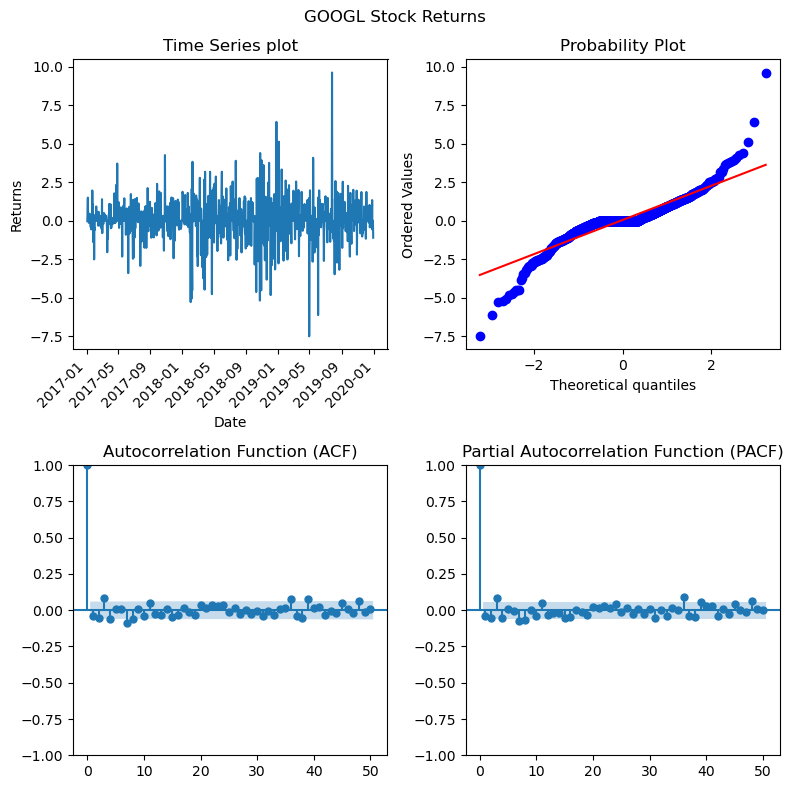

In [57]:
# Plottig the stock returns

def plot_stock_ts(ts,lags,title):

    mosaic = """
    AB
    CD
    """
    fig = plt.figure(figsize=(8,8))
    ax = fig.subplot_mosaic(mosaic)

    ax['A'].plot(ts)
    ax['A'].set_title("Time Series plot")
    ax['A'].set_xlabel("Date")
    ax['A'].set_ylabel("Returns")
    plt.setp(ax['A'].get_xticklabels(), rotation=45, ha="right")
    # Probability plot
    probplot(ts, plot=ax['B'])
    ax['B'].set_title("Probability Plot")

    # ACF plot
    plot_acf(ts, lags=lags, ax=ax['C'])
    ax['C'].set_title("Autocorrelation Function (ACF)")

    # PACF plot
    plot_pacf(ts, lags=lags, ax=ax['D'])
    ax['D'].set_title("Partial Autocorrelation Function (PACF)")

    fig.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()


plot_stock_ts(returns, lags=50,title=f'{ticker} Stock Returns')


The volatility plot shows **volatility clustering** i.e. large changes tend is followed by large changes, of either sign, and small changes tend to be followed by small changes.

## GARCH(1,1) Models

GARCH(1,1) has only one parameter of each kind in it.
The equation has three constants: $\alpha$, $\beta$ and $\omega$. The $\omega$ parameter behaves like a con-
stant volatility you expect in a homoscedastic model while the $\alpha$ and $\beta$ parameters 
are a generalisation of the parameters in an exponentially weighted moving average model. 

The formula is:

$GARCH(1,1):\sigma_{t}^2=\omega+\alpha \epsilon^2_{t−1}+\beta \sigma^2_{t−1}$

Sometimes  the  constant  $\beta$  is  called  the  persistence 
because if it’s large, sharp rises in volatility take a long time to die down. The 
constant $\alpha$ is sometimes called the reaction because it determines how the volatility is affected by the latest return data.


In [65]:
basic_gm = arch_model(returns, vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
# Fit the model
gm_result = basic_gm.fit(last_obs = start_date, update_freq = 10)


ValueError: first_obs and last_obs produce in an empty array.

In [59]:
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1701.42
Distribution:                  Normal   AIC:                           3410.84
Method:            Maximum Likelihood   BIC:                           3430.82
                                        No. Observations:                 1091
Date:                Thu, Aug 15 2024   Df Residuals:                     1090
Time:                        22:07:06   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0676  3.486e-02      1.939  5.253e-02 [-7.39

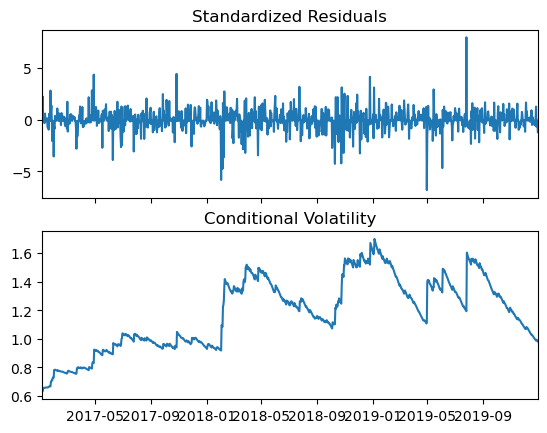

In [60]:
# Plot fitted results
gm_result.plot()
plt.show()

### Distribution of residuals

GARCH models assumes that we have standardised residuals (residual / return volatility) have stadard normal distribution. 

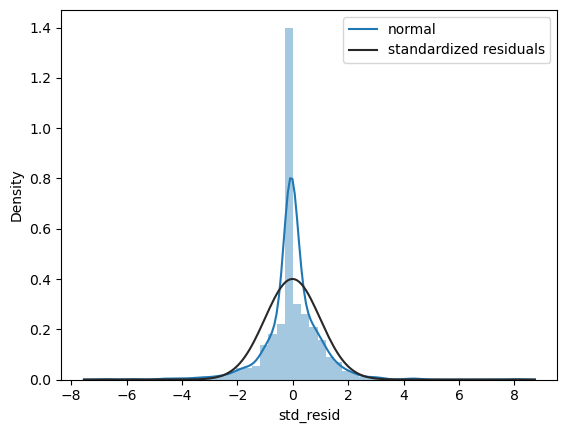

In [61]:
import seaborn as sns 

sns.distplot(gm_result.std_resid,norm_hist=True, fit=stats.norm)
plt.legend(('normal', 'standardized residuals'))
plt.show()

We observe that the standardized residuals are not modelled well by the assumption of normal distribution. We can try to model residuals using t-distribution which has fatter tails.

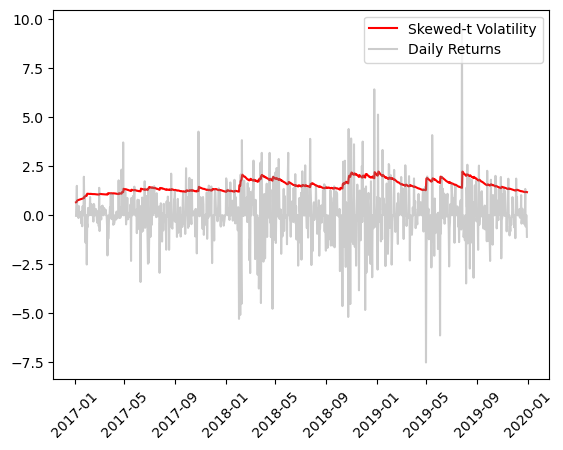

In [62]:
# Specify GARCH model assumptions
skewt_gm = arch_model(returns, p = 1, q = 1, mean = 'Zero', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility
# Plot model fitting results
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(returns, color = 'grey', 
        label = 'Daily Returns', alpha = 0.4)
plt.legend(loc = 'upper right')

plt.xticks(rotation = 45)
plt.show()

## ARMA + ARCH Modeling

In the my previous analysis in the notebook Time_series_analysis.ipynb we discussed ARMA modeling.
In the following section I am going to model the stock price using the ARIMA model I used in that notebook.
I model the log stock returns using ARIMA followed by fitting the residuals with ARCH model.

In [21]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")


model = auto_arima(prices, start_p=0, start_q=0,
            test='adf',       
            max_p=12, max_q=12,             
            d=1,           
            seasonal=True, 
            trace=True,
            error_action='ignore',  
            suppress_warnings=True, 
            stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2207.377, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2208.173, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2208.035, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2206.845, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2206.837, Time=0.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2200.991, Time=1.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2206.869, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2201.640, Time=1.01 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2197.278, Time=1.46 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2201.470, Time=0.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2199.265, Time=1.78 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2199.264, Time=1.70 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2202.112, Time=1.25 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2197.787, Time=3.90 sec
 ARIMA(2,1,2)(0,0,0)[0]          

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1092
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1093.442
Date:                Thu, 15 Aug 2024   AIC                           2196.883
Time:                        21:57:19   BIC                           2221.858
Sample:                    01-03-2017   HQIC                          2206.335
                         - 12-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1280      0.090    -12.469      0.000      -1.305      -0.951
ar.L2         -0.8079      0.084     -9.565      0.000      -0.973      -0.642
ma.L1          1.1021      0.102     10.802      0.000       0.902       1.302
ma.L2          0.7361      0.098      7.483      0.000       0.543       0.929
sigma2         0.4345      0.008     53.293      0.000       0.419       0.451
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4377.47
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               3.59   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00954D+00    |proj g|=  1.35573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      6      1     0     0   2.177D-05   1.010D+00
  F =   1.0095442124917491     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


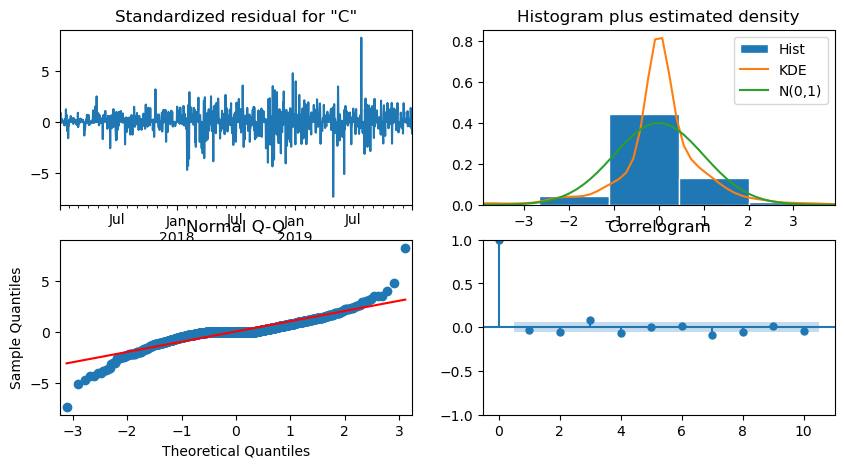

In [25]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=prices,order=(0, 1, 0))
_model_result = _arma_model.fit()
# Plot model residuals
_model_result.plot_diagnostics(figsize=(10, 5))
plt.show()

In [26]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1125.87
Distribution:                  Normal   AIC:                           2257.75
Method:            Maximum Likelihood   BIC:                           2272.73
                                        No. Observations:                 1092
Date:                Thu, Aug 15 2024   Df Residuals:                     1092
Time:                        21:57:45   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1995  7.259e-02      2.748  5.992e-03  [5.72

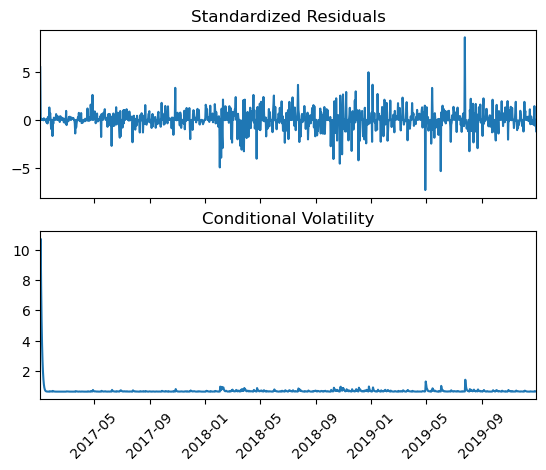

In [27]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.xticks(rotation = 45)
plt.show()

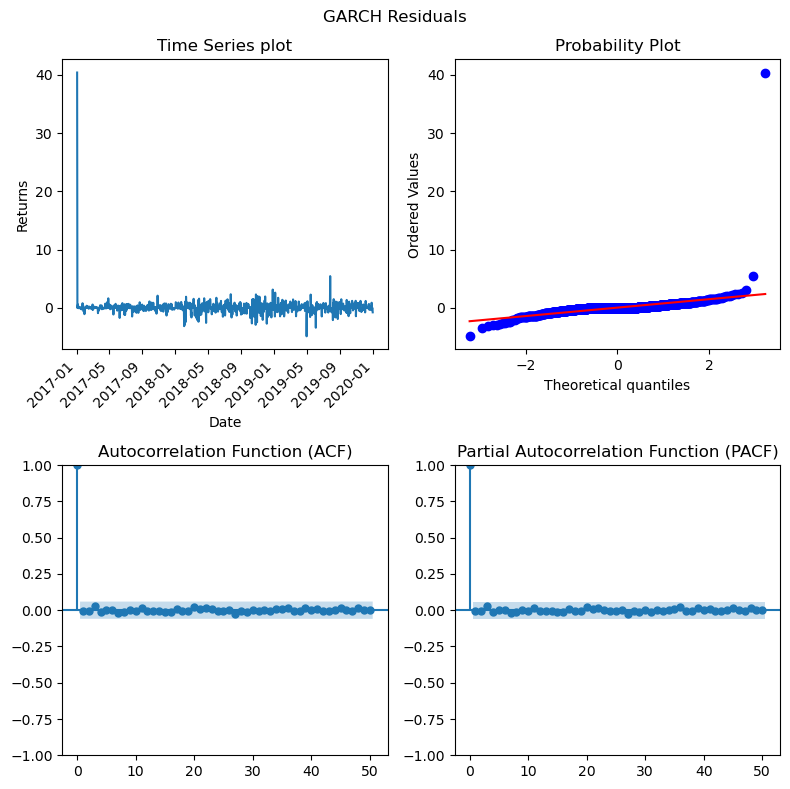

In [28]:
plot_stock_ts(_garch_result.resid.dropna(), lags=50, title='GARCH Residuals')


## Information assymetry

Vanilla GARCH assumes the bad and good news to affect the price market response equally which might not be the case due to leverage effect. As the stock prices go down (in case of bad news) the debt-to-equity ratio (DER) of the company goes up and the stock becomes risky. People try to minimise thier risk in such a situation resulting in skewed response in case of bad news. Negative news tends to affect the volatility more than positive news.

Two models that can deal with the information assymmetry are GJR-GARCH and EGARCH (Exponential GARCH)





### GJR GARCH

If the conditional variance of the GARCH(1,1) model at time $ t $ as $ h_t $, and the corresponding conditional standard deviation as $ \sigma_t $. The basic GARCH(1,1) model can be represented by the following equations:


\begin{align*}
h_t &= \omega + \alpha \cdot \varepsilon_{t-1}^2 + \beta \cdot h_{t-1} \\
\sigma_t &= \sqrt{h_t}
\end{align*}


Here:
- $\omega $ is a constant term,
- $\alpha $ and $ \beta $ are coefficients,
- $\varepsilon_{t-1} $ is the lagged (previous time step) standardized residual.

The GJR GARCH(1,1) model introduces an additional parameter $ \gamma $ to account for asymmetry. The formulation is as follow$


\begin{align*}
h_t &= \omega + \alpha \cdot \varepsilon_{t-1}^2 + \beta \cdot h_{t-1} + \gamma \cdot \varepsilon_{t-1}^2 \cdot I_{\{\varepsilon_{t-1} < 0\}} \\
\sigma_t &= \sqrt{h_t}
\end{align*}


Here:
- $ I_{\{\varepsilon_{t-1} < 0\}} $ is an indicator function that equals 1 if $ \varepsilon_{t-1} < 0 $ and 0 otherwise.
- The additional term $ \gamma \cdot \varepsilon_{t-1}^2 \cdot I_{\{\varepsilon_{t-1} < 0\}} $ captures the asymmetry by allowing the impact of negative shocks to differ from positive shocks.

This modification allows the GJR GARCH model to account for the fact that volatility may respond differently to positive and negative shocks. 

In [34]:
# Specify GJR-GARCH model assumptions
gjr_gm = arch_model(returns, p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')

# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -44205.9
Distribution:      Standardized Student's t   AIC:                           88423.8
Method:                  Maximum Likelihood   BIC:                           88453.7
                                              No. Observations:                 1091
Date:                      Thu, Aug 15 2024   Df Residuals:                     1090
Time:                              21:59:10   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

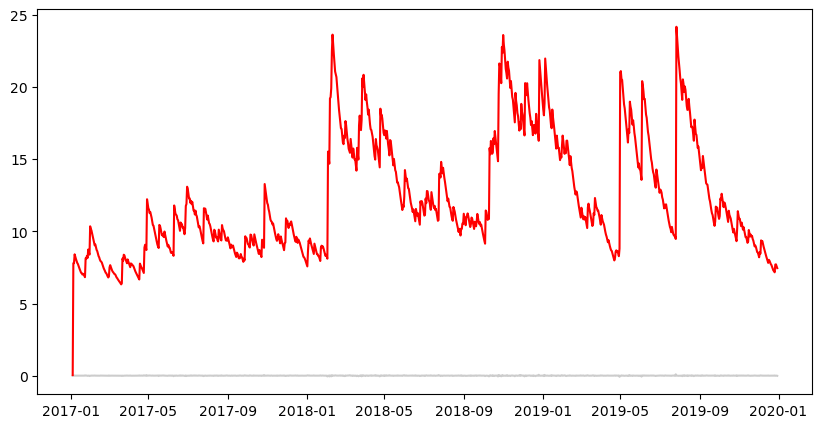

In [35]:
# Plot the Returns in grey and GJR-GARCH in red

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(returns, color = 'grey', alpha = 0.4, label = 'Price Returns')
ax.plot(gjrgm_result.conditional_volatility, color = 'red', label = 'GJR-GARCH')

### Exponential GARCH (EGARCH)

The Exponential Generalized Autoregressive Conditional Heteroskedasticity (EGARCH) model, like the GARCH model, is used to model and forecast volatility in financial time series data. The key distinction lies in how they model the conditional variance.

The GARCH model assumes that volatility responds symmetrically to positive and negative shocks. On the other hand, the EGARCH model allows for asymmetric responses by modeling the logarithm of conditional variance. The EGARCH(1,1) model can be expressed as follows:

$ \log(h_t) = \omega + \alpha |\varepsilon_{t-1}| + \beta \log(h_{t-1}) $

Here:
- $\omega $ is a constant term,
- $\alpha $ and $ \beta $ are coefficients,
- $\varepsilon_{t-1} $ is the lagged (previous time step) standardized residual.

The key difference is the term $ \alpha |\varepsilon_{t-1}| $, where $ |\varepsilon_{t-1}| $ is the absolute value of the lagged standardized residual. This term allows for a direct and asymmetric impact of past shocks on the conditional variance.

Therefore, EGARCH model incorporates asymmetry in volatility more explicitly than the GARCH model by using the absolute value of past shocks in the formulation. 

In [44]:
# Specify EGARCH model assumptions
egarch_gm = arch_model(returns, p = 1, q = 0, o = 1, vol = 'EGARCH', dist = 't')

# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EARCH Model Results                         
Dep. Variable:                        Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            EARCH   Log-Likelihood:                3548.92
Distribution:      Standardized Student's t   AIC:                          -7087.84
Method:                  Maximum Likelihood   BIC:                          -7062.86
                                              No. Observations:                 1091
Date:                      Thu, Aug 15 2024   Df Residuals:                     1090
Time:                              22:00:50   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

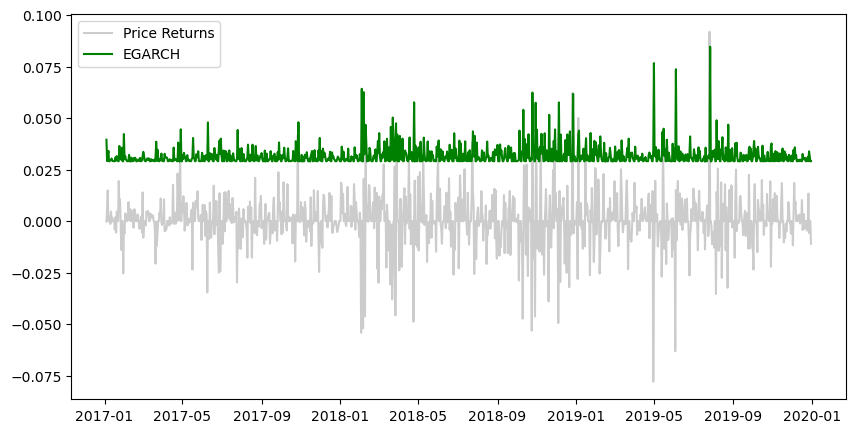

In [43]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(returns, color = 'grey', alpha = 0.4, label = 'Price Returns')
# ax.plot(gjrgm_result.conditional_volatility, color = 'red', label = 'GJR-GARCH')
ax.plot(egarch_result.conditional_volatility, color = 'green', label = 'EGARCH')

ax.legend()

In [45]:
# Print each models BIC
print(f'GJR-GARCH BIC: {gjrgm_result.bic}')
print(f'\nEGARCH BIC: {egarch_result.bic}')

GJR-GARCH BIC: 88453.73986088586

EGARCH BIC: -7062.864158118565


Both models performed well in computing the volatility of the stock prices but GJR-GARCH yeilds a little better estimates compared to EGARCH.

## Focasting

To forecast the volatility of a series using a GARCH model, one needs to estimate the parameters of the model using historical data. However, the parameters may not be constant over time, and may change due to structural breaks, regime shifts, or other factors. Therefore, one may want to use a rolling window approach, which updates the parameter estimates as new data becomes available, and discards old data that may not be relevant anymore.It allows the model to adapt to the changing dynamics of the series, and to capture the most recent information available.But, Requires more computational time and resources, and it may introduce some noise or instability in the forecasts, especially if the window size is too small or the series is very volatile.


### Rolling window approach

**Fixed Rolling Window**
- Split the data into overlapping windows of a fixed length. 
- Iterate over each window and estimate a GARCH model using the data within that window. For example, using the first window, estimate the parameters ω, α, and β by maximizing the likelihood function of the GARCH model.
- Make forecasts using the estimated GARCH model and record the results. For example, using the parameters estimated from the first window, forecast the conditional variance of the series for the next 20 days, and store the forecasts in a matrix or a vector.
- Slide the window forward by one observation and repeat steps 2 and 3 until the end of the data is reached. For example, using the second window, estimate the parameters again, forecast the conditional variance for the next 20 days, and append the forecasts to the previous ones.

**Expanding Rolling Window**

Instead of taking data within sliding fixed window in each iteration the window width is increaed to include all the previous values.

In [ ]:

# Fixed rolling window size
window_size = 50 

# Number of observations in the dataset
n_obs = stocks.shape[0]


# List to store forecast results
forecast_values = []
volatility_estimates=[]
# Perform fixed window GARCH(1,1) estimation
for i in range(window_size, len(stocks)):
    current_window = stocks.Log_Return[i - window_size:i]
    # Fit GARCH(1,1) model
    model = arch_model(current_window, mean='Zero', p=1, q=1)
    result = model.fit(disp='off')

    
    # Retrieve the conditional volatility for the last observation in the window
    # last_volatility = result.conditional_volatility.iloc[-1]
    variance =result.forecast(horizon=1).variance.iloc[-1].values[0]
    
    # Append the result to the list
    volatility_estimates.append(variance**0.5)


# Create a DataFrame with dates and volatility estimates
fixed_window_df = pd.DataFrame({
    'Date': stocks.index[window_size:],
    'Volatility': volatility_estimates
})



### Expanding Rolling Window 

In [ ]:

# Fixed rolling window size
window_size = 50

# Number of observations in the dataset
n_obs = stocks.shape[0]


# List to store forecast results
forecast_values = []
volatility_estimates=[]
# Perform fixed window GARCH(1,1) estimation
for i in range(window_size, len(stocks)):
    current_window = stocks.Log_Return[:i]
    # Fit GARCH(1,1) model
    model = arch_model(current_window, mean='Zero', p=1, q=1)
    result = model.fit(disp='off')
    # Retrieve the conditional volatility for the last observation in the window
    # last_volatility = result.conditional_volatility.iloc[-1]
    variance =result.forecast(horizon=1).variance.iloc[-1].values[0]
    
    # Append the result to the list
    volatility_estimates.append(variance**0.5)

# Create a DataFrame with dates and volatility estimates
expanding_window_df = pd.DataFrame({
    'Date': stocks.index[window_size:],
    'Volatility': volatility_estimates
})



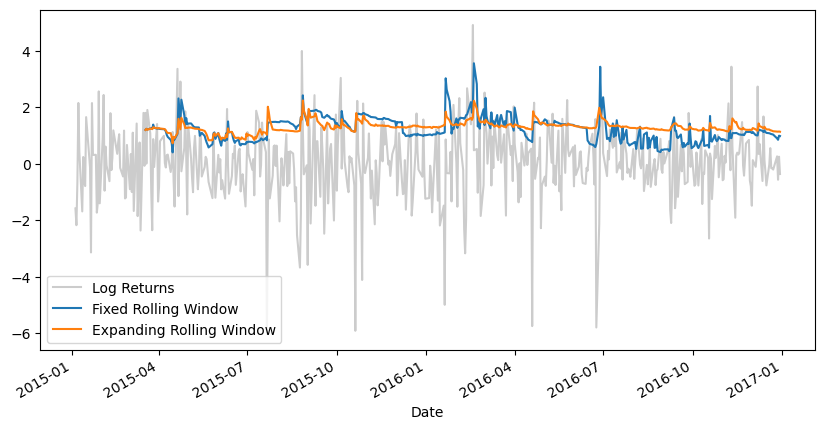

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
stocks['Log_Return'].plot(ax=ax,color='grey', alpha = 0.4, label = 'Price Returns')
fixed_window_df.plot(ax=ax,x='Date', y='Volatility', kind='line')
expanding_window_df.plot(ax=ax,x='Date', y='Volatility', kind='line')

ax.legend(['Log Returns', 'Fixed Rolling Window', 'Expanding Rolling Window'])

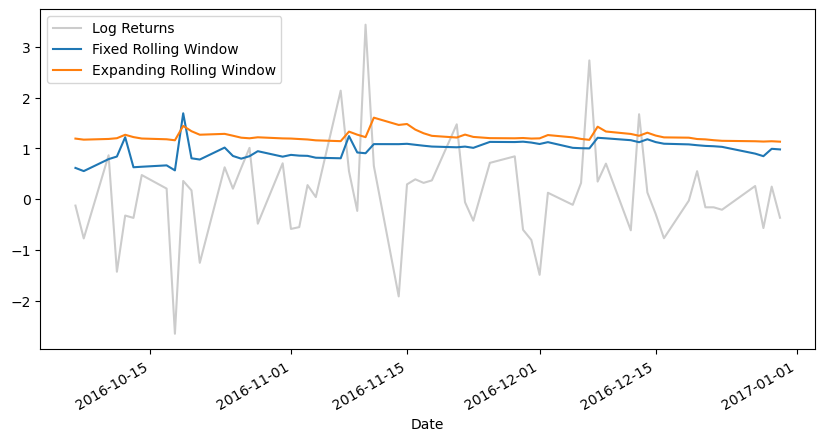

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
stocks['Log_Return'][-60:].plot(ax=ax,color='grey', alpha = 0.4, label = 'Price Returns')
fixed_window_df[-60:].plot(ax=ax,x='Date', y='Volatility', kind='line')
expanding_window_df[-60:].plot(ax=ax,x='Date', y='Volatility', kind='line')

ax.legend(['Log Returns', 'Fixed Rolling Window', 'Expanding Rolling Window'])

Both are able to capture the volatility of log returns. We observe that expanding rolling window estimates are smoother compared to fixed rolling window case.

## Simulating Forecasts

1. **Bootstrap in ARCH Models:**
   - Bootstrap methods in ARCH models are often used for estimating the uncertainty or distribution of a statistic (e.g., volatility forecast) by resampling from the residuals of the fitted model.
   - After estimating an ARCH model, residuals are resampled with replacement to create multiple bootstrap samples. The model is then re-estimated for each bootstrap sample, and the volatility is forecasted for each resample. This process generates a distribution of forecasts, which can be used for constructing confidence intervals or assessing uncertainty.
   - Bootstrapping may involve generating multiple paths of future volatility by resampling from the observed residuals.

2. **Simulation in ARCH Models:**
   - Simulation methods in ARCH models aim to generate future paths of the time series, including volatility, by simulating from the estimated model.
   - Given the estimated parameters of the ARCH model, simulations involve repeatedly generating random draws of residuals from the estimated distribution and using them to simulate future values of the time series.
   - Simulating paths of future volatility involves drawing random shocks from the estimated volatility distribution and using them to simulate future volatility values.

In summary, while both bootstrap and simulation methods involve generating multiple scenarios to assess uncertainty, the key distinction lies in their objectives. Bootstrapping is often associated with estimating the distribution of a statistic (e.g., forecasted volatility) by resampling from the observed residuals. On the other hand, simulation methods aim to generate synthetic paths of the time series itself, often by drawing random shocks from the estimated model.

In practice, the terms may be used interchangeably, and the choice between them depends on the specific goals of the analysis and the questions being addressed.

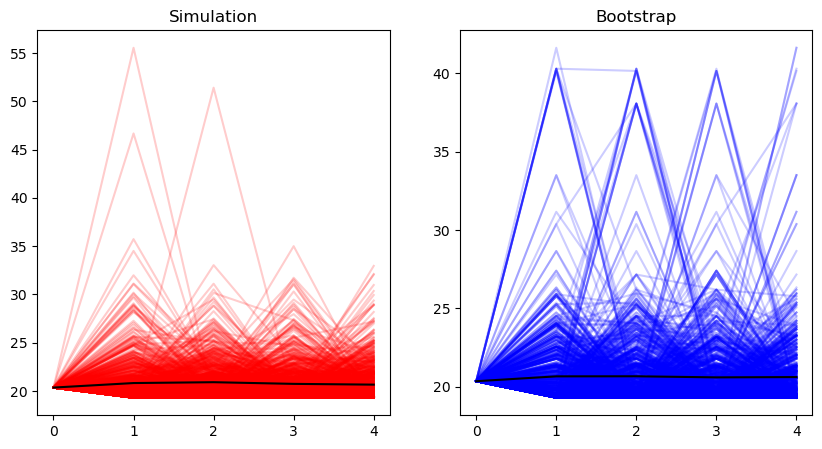

In [ ]:
# forecast egarch using the two different methods
sim_f = egarch_result.forecast(horizon=5, method='simulation')
sim_paths = sim_f.simulations.residual_variances[-1].T
sim = sim_f.simulations

bs_f = egarch_result.forecast(horizon=5, method='bootstrap')
bs_paths = bs_f.simulations.residual_variances[-1].T
bs = bs_f.simulations

# Plot paths of both approaches

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(range(5),np.sqrt(252*sim_paths), color = 'red', label = 'Simulation',alpha=0.2)
ax[0].plot(range(5),np.sqrt(252*bs_f.residual_variance.iloc[-1]),color='k', alpha=1)

ax[1].plot(range(5),np.sqrt(252*bs_paths), color = 'blue', label = 'Bootstrap',alpha=0.2)
ax[1].plot(range(5),np.sqrt(252*sim_f.residual_variance.iloc[-1]),color='k', alpha=1)

ax[0].set_title('Simulation')
ax[1].set_title('Bootstrap')
plt.show()

## CCC-GARCH model 


The Bollerslev’s CCC-GARCH (Constant Conditional Correlation GARCH) model is a type of multivariate GARCH model commonly used in financial econometrics to model the time-varying volatility and correlation between multiple assets. The model assumes that the **conditional correlation between assets remains constant over time**.

The CCC-GARCH model can be represented with the following equations:
$$
\begin{align*}
\bold{r} =&& \bold{\mu} - \bold{\epsilon_t} \\
\bold{\epsilon_{t}} \sim&& N(0,\bold{\Sigma_t})\\
\bold{\Sigma_t} =&& \bold{D_tRD_t}
\end{align*}
$$

where:
   - $ \bold{r_t}$ is vector of returns similarly $\bold{\mu}$ is mean vector.
   - $\bold{\epsilon}$ is error term from a Multivariate Normal distribution.
   - $\bold{\Sigma_t}$ is conditional covariance matrix.

Elements of $\bold{\Sigma_t}$ are defined as:

- Diagonal: $\sigma_{ii}^2 = \omega_{ii}+\sum_{i=1}^{q} \alpha_{ii}\epsilon_{i,t-1}^{2} + \sum_{i=1}^{p} \beta_{ii} \sigma^{2}_{i,t-1}$ for $i=1,2,3...N$
- Off Diagonal: $\sigma_{ij,t}^2 = \rho_{i,j} \sigma_{ii,t}\sigma_{jj,t}$ for $i \neq j$

Third equation is decomposition of $\bold{\Sigma_t}$ with $\bold{D_t}$ matrix containing the conditional standard deviations on the diagonal, and $\bold{R_{t}}$ is a correlation matrix.

For a more details:

Engle, R. F. (2002). Dynamic Conditional Correlation: A Simple Class of Multivariate GARCH Models. *Journal of Business & Economic Statistics, 20*(3), 339–350. [Link](https://www.tandfonline.com/doi/abs/10.1198/073500102288618487)



In [ ]:
from arch import arch_model

import yfinance as yf
import pandas_datareader.data as pdr
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

yf.pdr_override()

# Define a list of stock symbols belonging to different sectors
# ['Apple', 'Procter & Gamble', 'JPMorgan Chase', 'Johnson & Johnson']

stock_symbols = ['AAPL', 'PG', 'JPM', 'JNJ']

# start date
start_date = '2015-01-01'
# end date
end_date = '2017-01-01'

# Fetch stock data along with sector information
portfolio = pdr.get_data_yahoo(stock_symbols,start_date,end_date)['Close']

# portfolio returns
portfolio_returns = portfolio.pct_change()*100
portfolio_returns.dropna(inplace=True)

# Generate random weights for each asset we have to optimize this
weights = np.random.rand(len(stock_symbols))
weights /= weights.sum()  # Normalize weights to ensure they sum up to 1


mod_params = []
cond_vol = []
std_res = []
models=[]
for asset in stock_symbols:
    # define the garch model GARCH(1,1)
    model = arch_model(portfolio_returns[asset], mean="Constant", 
    vol="GARCH", p=1, q=1)
    # fit the model
    model = model.fit(update_freq=0, disp="off");
    # store the model parameters, conditional volatility and standardized residuals
    mod_params.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_res.append(model.std_resid)
    models.append(model)

# make dataframes from model parameters
mod_params = pd.DataFrame(mod_params,index=portfolio_returns.columns)
# conditional volatilities
cond_vol = pd.DataFrame(np.array(cond_vol).T,columns=portfolio_returns.columns,index=portfolio_returns.index)
# standardized residuals
std_res = pd.DataFrame(np.array(std_res).T,columns=portfolio_returns.columns,index=portfolio_returns.index)

print("parameters for stocks: ")
print(mod_params)


[*********************100%%**********************]  4 of 4 completed
parameters for stocks: 
            mu     omega  alpha[1]   beta[1]
AAPL  0.067190  0.238914  0.106226  0.798369
JNJ   0.004953  0.285586  0.159362  0.539246
JPM   0.130649  0.228488  0.287337  0.636582
PG    0.043582  0.035722  0.079878  0.879122


constant conditional correlation matrix (R) is calculated as the unconditional correlation matrix of standardised residuals:

$\bold{R} = \frac{1}{T} \sum_{t=1}^{T}\bold{z_{t}z_{t}^\prime}$

In [ ]:
# get the correlation matrix R
R = std_res.T@std_res/portfolio_returns.shape[0]

In [ ]:
# Get one step forcast for $\Sigma$

# Get place holder for D_{t}
Dt = np.zeros((len(stock_symbols),len(stock_symbols)))
diag_elements = []

for model in models:
    # Get the diagonal elements
    diag_elements.append(model.forecast(horizon=1).variance.iloc[-1,0])

# get volatilities
diag_elements = np.sqrt(diag_elements)
# fill the Dt
np.fill_diagonal(Dt,diag_elements)

# Get Sigma

Sigma = Dt@R.values@Dt

print(Sigma)


[[1.37185475 0.33886194 0.43828859 0.29984589]
 [0.33886194 0.67362832 0.28276209 0.31400021]
 [0.43828859 0.28276209 0.91142876 0.346039  ]
 [0.29984589 0.31400021 0.346039   0.57011301]]


You can use the $\Sigma$ to do the forcasting of returns and 

## Model Evaluation

### Parameters evaluation

The significance of a model parameters cab ve evaluated by looking at the p-value of the parameters. The null hypothesis H0: "the parameter value is zero". If the the p-value is more than the significance threshold (normally 0.05) the hypothesis can't be rejected and the parameter is considered insignificant.

In [ ]:
# from the model summary get the p-values
para_summary = pd.DataFrame({'parameter':gm_result.params,
                            'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

          parameter   p-value
mu         0.006345  0.909187
omega      0.413006  0.071593
alpha[1]   0.099346  0.114310
beta[1]    0.654551  0.000003


All the parameters have p-value less than the threshold, therefore are retained

### Fit evaluation

**Maximum Likelihood (ML):**
- **Explanation:** Maximum Likelihood is a statistical method for estimating the parameters of a model by maximizing the likelihood function, which measures how well the model explains the observed data.
- **Key Idea:** The parameter values are chosen to maximize the probability (likelihood) of observing the given data under the assumed statistical model.
- **Objective:** Find the parameter values that make the observed data most probable given the model.


In [ ]:
# Get the log-likelihood of normal GARCH
print('LLH normal GARCH :', gm_result.loglikelihood)
# Get the log-likelihood of skewt GARCH
print('LLH skewt GARCH :', skewt_result.loglikelihood)

LLH normal GARCH : -835.2073275607388
LLH skewt GARCH : -803.5026119867615


The log likelihood shows that the skewed GARCH performed better than the normal GARCH

### Mean Absolute Error and Mean Squared Error




In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(stocks['Return'].sub(stocks['Return'].mean()).pow(2), gm_result.conditional_volatility**2)

mse = mean_squared_error(stocks['Return'].sub(stocks['Return'].mean()).pow(2), gm_result.conditional_volatility**2)

print(f"Mean Absolute Error: {mae}, Mean Squared Error: {mse}")

Mean Absolute Error: 1.8060100375994574, Mean Squared Error: 14.472453912107826
